In [1]:
import sys
sys.path.append("./utils/") # Adds higher directory to python modules path.
import random
import numpy as np
import cv2
import yaml
import glob, os
import loadcoraldata_utils as coralutils
import json
import importlib
from NeMO_generator import NeMOImageGenerator, ImageSetLoader
from osgeo import gdal, ogr, osr

from matplotlib import colors
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
%matplotlib notebook

jsonpath = './utils/CoralClasses.json'
with open(jsonpath) as json_file:
    json_data = json.load(json_file)
consolclass_count = dict((k, 0) for k in json_data["VedConsolidated_ClassDict"])

cmap = colors.ListedColormap(['xkcd:pink', 'xkcd:grey', 'xkcd:tan', 'xkcd:olive', 'xkcd:forest', 'xkcd:blue',
                              'xkcd:lilac', 'xkcd:cyan', 'xkcd:orange'])

%matplotlib notebook

Using TensorFlow backend.
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [56]:
jsonpath = './utils/CoralClasses.json'
with open(jsonpath) as json_file:
    json_data = json.load(json_file)
consolclass_count = dict((k, 0) for k in json_data["VedConsolidated_ClassDict"])
cmap = colors.ListedColormap(['xkcd:pink', 'xkcd:grey', 'xkcd:tan', 'xkcd:olive', 'xkcd:forest', 'xkcd:blue',
                              'xkcd:lilac', 'xkcd:cyan', 'xkcd:orange'])

P_to_WV2 = 128.0

# Coordinates for Planet
xgeo = np.asarray([251600.0, 253479.0, 257200.0])
ygeo = np.asarray([8033931.0, 8040132.0, 8039001.0])
locations = len(xgeo)

# Coordinates for WV2
xgeo_WV2 = xgeo + P_to_WV2
ygeo_WV2 = ygeo - P_to_WV2

# WV2 files
specificfiles = ['/home/shared/NeMO-Net Data/processed_Fiji_files/mosaiced_001.TIF',
                '/home/shared/NeMO-Net Data/processed_Fiji_files/mosaiced_002.TIF',
                '/home/shared/NeMO-Net Data/processed_Fiji_files/mosaiced_003.TIF']


output_trainpath = '../Images/ForJarrett_SpecificTrainTruth_512/'
output_trainrefpath = '../Images/ForJarrett_SpecificTrainTruth_512/'
output_trainfilename = 'CoralInfo.txt'
if not os.path.exists(output_trainpath):
    os.makedirs(output_trainpath)
if not os.path.exists(output_trainpath):
    os.makedirs(output_trainrefpath)

counter = 0
bandstoexport = [2,3,5]

f = open(output_trainpath + output_trainfilename,'w')
for filepath in specificfiles:
    for i in range(locations):
        Fiji = coralutils.CoralData(filepath, load_type="raster")
        imgshape = Fiji.image.shape
        xstart_WV2 = int((xgeo_WV2[i]-Fiji.geotransform[0])/Fiji.geotransform[1])
        ystart_WV2 = int((ygeo_WV2[i]-Fiji.geotransform[3])/Fiji.geotransform[5])
        xlen = 512
        ylen = 512

        if xstart_WV2+xlen > imgshape[1] or xstart_WV2 < 0 or ystart_WV2+ylen > imgshape[0] or ystart_WV2 < 0:
            print("Image out of bounds!")
        else:
            tempimage = Fiji.image[ystart_WV2:ystart_WV2+ylen, xstart_WV2:xstart_WV2+xlen, :]
            trainstr = 'Coral_' + str(counter).zfill(8) + '.png'
            tempimage_export = np.zeros((tempimage.shape[0], tempimage.shape[1], 3))
            counter2 = 0
            for chan in bandstoexport:
                tempchannel = tempimage[:,:,chan-1]
                tempchannel[tempchannel > 255] = 255
                tempchannel[tempchannel < 0 ] = 0
                tempimage_export[:,:,counter2] = tempchannel
                counter2 += 1
            cv2.imwrite(output_trainpath+trainstr, tempimage_export)
            counter += 1     
            f.write(filepath + ' ' + str(ystart_WV2) + ' ' + str(xstart_WV2) + '\n')
f.close()


In [57]:
import math

def calc_d_ES( AcqTime ):
    AcqTime = AcqTime.strip()
    print(AcqTime)
    year    = int(AcqTime[0:4])
    month_  = AcqTime[5:7]
    month   = int(month_.lstrip("0"))
    day_    = AcqTime[8:10]
    day     = int(day_.lstrip("0"))
    hh_     = AcqTime[11:13]
    hh      = float(hh_.lstrip("0"))
    mm_     = AcqTime[14:16]
    mm      = float(mm_.lstrip("0"))
    ss_     = AcqTime[17:19]
    ss      = float(ss_.lstrip("0"))
    ms    = float(AcqTime[20:-1])
    sec   = ss + ms/(1e6)
    
    UT   = hh + mm/60. + sec/3600.
    #print("UT: ",UT)
    
    if (month == 1 or month == 2):
        year = year - 1
        month= month + 12
        
    # calculate Juliad Day (Meeus, p.61, 1998)
    A = int(year/100)
    B = 2 - A + int(A/4)
    JD= int(365.25*(year+4716)) + int(30.6001*(month + 1)) + day + UT/24. + B - 1524.5
    #print("Julian Day: ", JD)
    # calculate Earth-Sun distance (U.S. Naval Observatory)
    D  = JD - 2451545.0
    g  = 357.529 + 0.98560028*D
    gi = math.cos(math.radians(g))
    gi2= math.cos(math.radians(2*g))
    
    d_ES = 1.00014 - 0.01671*gi - 0.00014*gi2
    #print(d_ES)
    
    return (d_ES)**2

def fixRGBimg(img,pixel_mean,pixel_std,minval,maxval,dtype=np.uint8):
    fixed_img = np.copy(img)
    if type(pixel_std) == list:
        for i,std in enumerate(pixel_std):
            fixed_img[:,:,i] = fixed_img[:,:,i]*std+pixel_mean
    else:
        fixed_img = fixed_img*pixel_std+pixel_mean
    fixed_img[fixed_img > maxval] = maxval
    fixed_img[fixed_img < minval] = minval
    fixed_img = np.asarray(fixed_img, dtype=dtype)
    return fixed_img

# Planet files
specificfiles = ['/home/shared/NeMO-Net Data/Planet/Cicia/planet_order_336801/20181216_214344_0f35/20181216_214344_0f35_3B_AnalyticMS.tif',
                '/home/shared/NeMO-Net Data/Planet/Cicia/planet_order_411635/20190201_214454_101e/20190201_214454_101e_3B_AnalyticMS.tif',
                '/home/shared/NeMO-Net Data/Planet/Cicia/planet_order_411635/20190307_220637_1053/20190307_220637_1053_3B_AnalyticMS.tif',
                '/home/shared/NeMO-Net Data/Planet/Cicia/planet_order_411635/20190512_215344_1020/20190512_215344_1020_3B_AnalyticMS.tif',
                '/home/shared/NeMO-Net Data/Planet/Cicia/planet_order_411635/20190307_220638_1053/20190307_220638_1053_3B_AnalyticMS.tif',
                '/home/shared/NeMO-Net Data/Planet/Cicia/planet_order_411635/20190512_215344_1020/20190512_215344_1020_3B_AnalyticMS.tif',
                '/home/shared/NeMO-Net Data/Planet/Cicia/planet_order_411635/20191013_215135_1012/20191013_215135_1012_3B_AnalyticMS.tif']


output_trainpath = '../Images/ForJarrett_SpecificTrainTruth_512/'
output_trainrefpath = '../Images/ForJarrett_SpecificTrainTruth_512/'
output_trainfilename = 'CoralInfo.txt'
if not os.path.exists(output_trainpath):
    os.makedirs(output_trainpath)
if not os.path.exists(output_trainpath):
    os.makedirs(output_trainrefpath)

bandstoexport = [1,2,3]

f = open(output_trainpath + output_trainfilename,'a')
for filepath in specificfiles:
    for i in range(locations):
        Fiji = coralutils.CoralData(filepath, load_type="raster")
        imgshape = Fiji.image.shape
        xstart = int((xgeo[i]-Fiji.geotransform[0])/Fiji.geotransform[1])
        ystart = int((ygeo[i]-Fiji.geotransform[3])/Fiji.geotransform[5])
        xlen = 512
        ylen = 512
        
        TOA_radiance_img = fixRGBimg(Fiji.image,0,0.01,0,10000,np.float32)
        ff = filepath.split("_3B_")
        jsonpath = ff[0] + '_metadata.json'
        with open(jsonpath) as json_file:
            json_data = json.load(json_file)
        AcqTimeAll = json_data["properties"]['acquired']
        d_ES_sq = calc_d_ES(AcqTimeAll)
        meanSZA = 90.-json_data["properties"]["sun_elevation"]
        mu = math.cos(math.radians(meanSZA))
        GEO_radiance_img = (TOA_radiance_img*d_ES_sq)/mu

        if xstart+xlen > imgshape[1] or xstart < 0 or ystart+ylen > imgshape[0] or ystart < 0:
            print("Image out of bounds!")
        else:
            tempimage = GEO_radiance_img[ystart:ystart+ylen, xstart:xstart+xlen, :]
            
            if np.sum(np.sum(tempimage,-1) == 0) > 100:
                print("Too many black pixels!")
            else:
                trainstr = 'Coral_' + str(counter).zfill(8) + '.png'
                tempimage_export = np.zeros((tempimage.shape[0], tempimage.shape[1], 3))
                counter2 = 0
                for chan in bandstoexport:
                    tempchannel = tempimage[:,:,chan-1]
                    tempchannel[tempchannel > 255] = 255
                    tempchannel[tempchannel < 0 ] = 0
                    tempimage_export[:,:,counter2] = tempchannel
                    counter2 += 1
                cv2.imwrite(output_trainpath+trainstr, tempimage_export)
                counter += 1     
                f.write(filepath + ' ' + str(ystart) + ' ' + str(xstart) + '\n')
f.close()

2018-12-16T21:43:44.803677Z
2018-12-16T21:43:44.803677Z
Image out of bounds!
2018-12-16T21:43:44.803677Z
Image out of bounds!
2019-02-01T21:44:54.748293Z
2019-02-01T21:44:54.748293Z
Too many black pixels!
2019-02-01T21:44:54.748293Z
Too many black pixels!
2019-03-07T22:06:37.351695Z
2019-03-07T22:06:37.351695Z
Image out of bounds!
2019-03-07T22:06:37.351695Z
Image out of bounds!
2019-05-12T21:53:44.323818Z
2019-05-12T21:53:44.323818Z
Too many black pixels!
2019-05-12T21:53:44.323818Z
2019-03-07T22:06:38.322152Z
Too many black pixels!
2019-03-07T22:06:38.322152Z
2019-03-07T22:06:38.322152Z
2019-05-12T21:53:44.323818Z
2019-05-12T21:53:44.323818Z
Too many black pixels!
2019-05-12T21:53:44.323818Z
2019-10-13T21:51:35.887451Z
Image out of bounds!
2019-10-13T21:51:35.887451Z
2019-10-13T21:51:35.887451Z


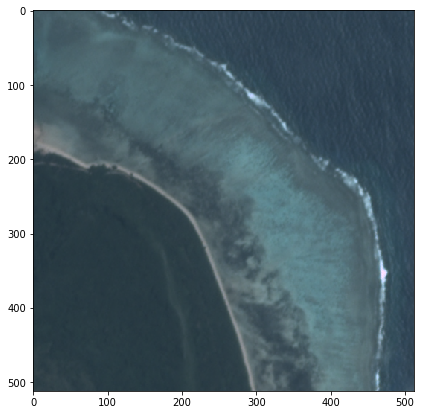

In [63]:
filepath = "/home/asli/NeMO-Test/NeMO-NET/Images/ForJarrett_SpecificTrainTruth_512/Coral_00000019.png"
Fijitest = coralutils.CoralData(filepath, load_type="cv2")

patch_R = Fijitest.image[:,:,2]
patch_G = Fijitest.image[:,:,1]
patch_B = Fijitest.image[:,:,0]
patch_R[patch_R > 255] = 255
patch_G[patch_G > 255] = 255
patch_B[patch_B > 255] = 255

Fiji_RGB = np.rollaxis(np.asarray([patch_R, patch_G, patch_B], dtype=np.uint8),0,3)
Fiji_RGB[Fiji_RGB > 255] = 255

fig = plt.figure(1,figsize=(20,7))
ax = plt.subplot(1,2,1)
ax.imshow(Fiji_RGB)

# filepath2 = "/home/asli/NeMO-Test/NeMO-NET/Images/ForJarrett_NemoNet_512/Coral/Coral_00000438.tif"
# Fijitest2 = coralutils.CoralData(filepath2, load_type="raster")
# patch_R = Fijitest2.image[:,:,2]
# patch_G = Fijitest2.image[:,:,1]
# patch_B = Fijitest2.image[:,:,0]
# patch_R[patch_R > 255] = 255
# patch_G[patch_G > 255] = 255
# patch_B[patch_B > 255] = 255

# Fiji_RGB2 = np.rollaxis(np.asarray([patch_R, patch_G, patch_B], dtype=np.uint8),0,3)
# Fiji_RGB2[Fiji_RGB2 > 255] = 255

# ax = plt.subplot(1,2,2)
# ax.imshow(Fiji_RGB2)
# plt.show()

In [49]:
# s = '/home/shared/NeMO-Net Data/Planet/Cicia/planet_order_336801/20181216_214344_0f35/20181216_214344_0f35_3B_AnalyticMS.tif'
# ff = s.split("_3B_")
# print(ff[0] + '_metadata.json')
tempimage = GEO_radiance_img[ystart:ystart+ylen, xstart:xstart+xlen, :]
print(np.sum(np.sum(tempimage,-1) == 0))

0
